In [1]:
import numpy as np
import pandas as pd
import os
import shutil
from flashgeotext.geotext import GeoText
import re

In [2]:
import hashlib

def md5hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()

In [3]:
record_col="UT (Unique WOS ID)"
outfile = r"C:\Users\radvanyi\PycharmProjects\ZSI_analytics\WOS\wos_extract\wos_records_concat.csv"

In [4]:
wos = pd.read_csv(outfile, sep="\t",low_memory=False)
print(f'Number of initial records: {len(wos)}')
metrix = pd.read_excel("sm_journal_classification.xlsx", sheet_name="Journal_Classification")


metrix = metrix.set_index([c for c in metrix.columns if "issn" not in c]).stack().reset_index()
metrix = metrix.rename(columns={'level_6':"issn_type", 0:"issn"})
metrix["issn"]=metrix["issn"].str.replace("-","").str.lower().str.strip()

wos["issn"] = wos["ISSN"].str.replace("-","").str.lower().str.strip()
wos["eissn"] = wos["eISSN"].str.replace("-","").str.lower().str.strip()
wos = wos.set_index([c for c in wos.columns if "issn" not in c]).stack().reset_index()
wos = wos.rename(columns={'level_71':"issn_var", 0:"issn"})

wos_merge = wos.merge(metrix, on="issn", how="left")
wos = wos_merge.sort_values(by="issn_var",ascending=False).drop_duplicates(subset=record_col)

# drop entries not indexed by metrix
wos = wos[~wos["Domain_English"].isna()]
# drop duplicates (based on doi)
wos = wos[~((~wos["DOI"].isna())&(wos["DOI"].duplicated(False)))]
wos = wos.drop_duplicates(subset=["Publication Type","Document Type","Authors","Article Title","Source Title","Publication Year"])
wos = wos[((wos["Publication Year"]<2023) & (~wos['Domain_English'].isna()))]
print(f'Number of filtered records: {len(wos)}')

Number of initial records: 41511
Number of filtered records: 35663


In [7]:
wos_cat = wos.groupby(record_col)["WoS Categories"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_cat["WoS Categories"] = wos_cat["WoS Categories"].str.strip()
wos_cat["WoS Categories"].value_counts()

WoS Categories
Engineering, Electrical & Electronic         9344
Computer Science, Artificial Intelligence    6045
Computer Science, Information Systems        5162
Telecommunications                           3929
Computer Science, Theory & Methods           2706
                                             ... 
Literature                                      1
Education, Special                              1
Demography                                      1
Social Work                                     1
Women's Studies                                 1
Name: count, Length: 234, dtype: int64

In [16]:
wos_subcat = wos_cat.copy()
wos_subcat[['WoS Category', 'WoS SubCategory']] = wos_subcat["WoS Categories"].str.split(",", expand = True, n=1)
for c in ['WoS Category', 'WoS SubCategory',"WoS Categories"]:
    wos_subcat[c] = wos_subcat[c].str.strip()
wos_subcat.drop_duplicates(subset=[record_col,'WoS Category'])["WoS Category"].value_counts()

WoS Category
Engineering                                  14168
Computer Science                             13807
Telecommunications                            3929
Imaging Science & Photographic Technology     2155
Automation & Control Systems                  1964
                                             ...  
Literature                                       1
Demography                                       1
Women's Studies                                  1
Social Work                                      1
Music                                            1
Name: count, Length: 176, dtype: int64

In [6]:
wos_areas = wos.groupby(record_col)["Research Areas"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_areas["Research Areas"] = wos_areas["Research Areas"].str.strip()
wos_areas["Research Areas"].value_counts()

Research Areas
Engineering                                  14204
Computer Science                             13807
Telecommunications                            3929
Environmental Sciences & Ecology              2156
Imaging Science & Photographic Technology     2155
                                             ...  
Cultural Studies                                 1
Asian Studies                                    1
Music                                            1
Demography                                       1
Social Work                                      1
Name: count, Length: 147, dtype: int64

In [101]:
wos[["Article Title","Keywords Plus","Author Keywords"]].sample(100)

Article Title   
28929  Superpixel Nonlocal Weighting Joint Sparse Rep...  \
8360   Graph topology enhancement for text classifica...   
42582  Application of machine learning and rough set ...   
32203  BUILDING ROBUST SPOKEN LANGUAGE UNDERSTANDING ...   
37519  Mining of High-Utility Patterns in Big IoT-bas...   
...                                                  ...   
21487  Long-range precipitation forecast based on mul...   
37473              Big data fusion in Internet of Things   
27468  An Effective Approach for Selection of Terrain...   
8955   BlockHammer: Improving Flash Reliability by Ex...   
67744  Deeply Supervised Salient Object Detection wit...   

                                           Keywords Plus   
28929  DIMENSIONALITY REDUCTION; FEATURE-EXTRACTION; ...  \
8360                                                 NaN   
42582  PREDICTIVE MAINTENANCE; FRAMEWORK; SELECTION; ...   
32203                                           NETWORKS   
37519            FREQUENT ITEMSETS; UNCERTAIN; DISCOVERY   
...                                                  ...   
21487  YANGTZE-RIVER BASIN; INTERDECADAL VARIABILITY;...   
37473                                                NaN   
27468                                     ERROR ANALYSIS   
8955   MEMORY; PERFORMANCE; RETENTION; ENDURANCE; OPT...   
67744                            IMAGE; ATTENTION; MODEL   

                                         Author Keywords  
28929  spatial-spectral fusion; joint sparse represen...  
8360   Text classification; Graph neural networks; To...  
42582  maintenance; availability; machine learning; d...  
32203  Spoken Language Understanding; NLU Robustness;...  
37519  IoT data analytics; Utility patterns; Data min...  
...                                                  ...  
21487  long range; multipole SSTA; preceding fluctuat...  
37473                                                NaN  
27468  Support vector machine (SVM); terrain classifi...  
8955   Reliability; Three-dimensional displays; Error...  
67744  Salient object detection; short connection; de...  

[100 rows x 3 columns]

In [102]:
kw_df = pd.DataFrame()
for c in ["Keywords Plus","Author Keywords"]:
    kwp = wos.groupby(record_col)[c].apply(lambda x: x.str.split(';')).explode().str.strip().str.upper()
    kwp.name = 'keyword_all'
    kw_df = pd.concat([kwp.reset_index(),kw_df],ignore_index=True)
kw_df = kw_df[~kw_df["keyword_all"].isna()].copy().drop(columns="level_1").drop_duplicates()
kw_df["keyword_all"] = kw_df["keyword_all"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
kw_df.head(100)

UT (Unique WOS ID)                 keyword_all
0    WOS:000208863600013        COMPARATIVE GENOMICS
1    WOS:000208863600013                     ANAMMOX
2    WOS:000208863600013    KUENENIA STUTTGARTIENSIS
3    WOS:000208863600013                METAGENOMICS
4    WOS:000208863600013          ENRICHMENT CULTURE
..                   ...                         ...
97   WOS:000209724300006               VIRTUAL DISKS
98   WOS:000209724300006      HETEROGENEOUS SERVICES
99   WOS:000209810700046  CORROSION CHARACTERIZATION
100  WOS:000209810700046          FEATURE EXTRACTION
101  WOS:000209810700046         PULSED EDDY CURRENT

[100 rows x 2 columns]

In [103]:
wos_kwd_concat = kw_df.groupby(record_col, as_index=False).agg({'keyword_all': '; '.join})
wos_kwd_concat.head()

UT (Unique WOS ID)                                        keyword_all
0  WOS:000208863600013  COMPARATIVE GENOMICS; ANAMMOX; KUENENIA STUTTG...
1  WOS:000208863600266  ANME; PYROSEQUENCING; AOM; COMMUNITY STRUCTURE...
2  WOS:000208863900217  DEFAULT MODE NETWORK; EFFECTIVE CONNECTIVITY; ...
3  WOS:000208972600008  BRAIN-MACHINE INTERFACE ; FIELD-PROGRAMMABLE G...
4  WOS:000209043200014  CYANOBACTERIA BLOOM; DRINKING WATER TREATMENT;...

In [104]:
wos.columns

Index(['Publication Type', 'Authors', 'Book Authors', 'Book Editors',
       'Book Group Authors', 'Author Full Names', 'Book Author Full Names',
       'Group Authors', 'Article Title', 'Source Title', 'Book Series Title',
       'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title',
       'Conference Date', 'Conference Location', 'Conference Sponsor',
       'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract',
       'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses',
       'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Name Preferred',
       'Funding Text', 'Cited References', 'Cited Reference Count',
       'Times Cited, WoS Core', 'Times Cited, All Databases',
       '180 Day Usage Count', 'Since 2013 Usage Count', 'Publisher',
       'Publisher City', 'Publisher Address', 'ISSN', 'eISSN', 'ISBN',
       'Journal Abbreviation', 'Journal ISO Abbreviation', 'Publication Date',
       'Publication Year', 'Volume', 'Issue', 'Pa

In [105]:
geotext = GeoText()

def extract_location(input_text, key='countries'):
    anomalies = {"Malta":"Malta",
                 "Mongolia":"Mongolia",
                 "Quatar":"Qatar",
                 "Qatar":"Qatar",
                 "Ethiop":"Ethiopia",
                 "Nigeria":"Nigeria",
                 "BELAR":"Belarus",
                 "Venezuela":"Venezuela",
                 "Cyprus":"Cyprus",
                 "Ecuador":"Ecuador",
                 "U Arab":"United Arab Emirates",
                 "Syria":"Syria",
                 "Uganda":"Uganda",
                 "Yemen":"Yemen",
                 "Mali":"Mali",
                 "Senegal":"Senegal",
                 "Vatican":"Vatican",
                 "Uruguay":"Uruguay",
                 "Panama":"Panama",
                 "Fiji":"Fiji",
                 "Faroe":"Faroe Islands",
                 "Macedonia":"Macedonia",
                 'Mozambique':'Mozambique',
                 "Kuwait":"Kuwait",
                 "Libya":"Libya",
                 "Turkiy":"Turkey",
                 "Liberia":"Liberia",
                 "Namibia":"Namibia",
                 "Ivoire":"Ivory Coast",
                 "Guatemala":"Gutemala",
                 "Paraguay":"Paraguay",
                 "Honduras":"Honduras",
                 "Nicaragua":"Nicaragua",
                 "Trinidad":"Trinidad & Tobago",
                 "Liechtenstein":"Liechtenstein",
                 "Greenland":"Denmark"}

    extracted = geotext.extract(input_text=input_text)
    found = extracted[key].keys()
    if len(sorted(found))>0:
        return sorted(found)[0]
    elif key=='countries':
        for i  in ['Scotland','Wales','England', 'N Ireland']:
            if i in input_text:
                return 'United Kingdom'
        for j in anomalies.keys():
            if j in input_text:
                return anomalies.get(j)
    else:
        return None

with open('../eu_members.txt',"r") as f:
    eu_countries=f.readline().split(",")
    eu_countries=[i.strip() for i in eu_countries]

def country_cleanup(country):
    if "USA" in country:
        return "USA"
    elif "China" in country:
        return "China"
    elif country in ["England", "Northern Ireland", "Wales", "Scotland","N Ireland"]:
        return "United Kingdom"
    else:
        return country


def country_type(country):
    if country in eu_countries:
        return "EU"
    elif country=="China":
        return "China"
    elif country in ["Switzerland", 'Norway','United Kingdom']:
        return "Non-EU associate"
    else:
        return "Other"


In [106]:
locations = wos.groupby(record_col)["Addresses"].apply(lambda x: x.str.split('[')).explode().reset_index().drop(columns="level_1")


locations = locations[locations["Addresses"]!=""].copy()
locations["Address"] = locations["Addresses"].apply(lambda x:x.split("]")[-1])
locations["Authors_of_address"] = locations["Addresses"].apply(lambda x:x.split("]")[0])

In [107]:
len(locations)

212138

In [108]:
locations["Address"] = locations["Address"].str.strip().str.strip(";")
locations = locations.groupby([record_col,"Authors_of_address"])["Address"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_2")
locations.head(100)

UT (Unique WOS ID)                                 Authors_of_address   
0   WOS:000208863600013                                         Hu, Baolan  \
1   WOS:000208863600013                                 Jetten, Mike S. M.   
2   WOS:000208863600013  Speth, Daan R.; Bosch, Niek; Keltjens, Jan T.;...   
3   WOS:000208863600013                               Stunnenberg, Henk G.   
4   WOS:000208863600266                                       Chen, Yifeng   
..                  ...                                                ...   
95  WOS:000209843500045                  Blautzik, Janusch; Meindl, Thomas   
96  WOS:000209843500045                               Breitner, John C. S.   
97  WOS:000209843500045                                  Buckner, Randy L.   
98  WOS:000209843500045  Calhoun, Vince D.; Courtney, William; King, Ma...   
99  WOS:000209843500045  Castellanos, F. Xavier; Colcombe, Stanley J.; ...   

                                              Address  
0   Zhejiang Univ, Dept Environm Engn, Hangzhou 31...  
1   Delft Univ Technol, Dept Biotechnol, Delft, Ne...  
2   Radboud Univ Nijmegen, Dept Microbiol, Inst Wa...  
3   Radboud Univ Nijmegen, Dept Mol Biol, Nijmegen...  
4   Chinese Acad Sci, Guangzhou Inst Geochem, Guan...  
..                                                ...  
95  Ludwig Maximilians Univ Munchen, Inst Clin Rad...  
96  McGill Univ, Douglas Inst, Dept Psychiat, Ctr ...  
97  Harvard Univ, Dept Psychol, Cambridge, MA 0213...  
98        Mind Res Network, Albuquerque, NM 87106 USA  
99  Nathan S Kline Inst Psychiat Res, Orangeburg, ...  

[100 rows x 3 columns]

In [109]:
# import dask.dataframe as dd
#
# locations_ddf = dd.from_pandas(locations, npartitions=4)  # convert pandas DataFrame to Dask DataFrame
# loc_compute = locations_ddf.groupby([record_col,"Authors_of_address"])["Address"].apply(lambda x: x.str.split(';')).explode().compute()  # compute the result

In [110]:
# locations_test = locations.head(1000)
# locations_test = locations_test.groupby([record_col,"Authors_of_address"])["Address"].str.split(';').explode()
# locations_test

In [111]:

# locations["Country"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='countries'))
locations["Country"]=locations['Address'].apply(lambda x: x.split(",")[-1].strip(" ").strip(";").strip(" "))
locations["Country"]=locations['Country'].apply(lambda x: country_cleanup(x))
locations["City"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='cities'))
locations["Country_Type"] = locations["Country"].apply(lambda x: country_type(x))

In [112]:
scope_types = ["EU","China","Non-EU associate"]
locations=locations[locations["Country_Type"].isin(scope_types)]

In [113]:
univ_locations = locations[[record_col,"Address","Country","City","Country_Type"]].copy()
univ_locations["Institution"] = univ_locations["Address"].apply(lambda x: x.split(",")[0])
univ_locations = univ_locations.drop_duplicates()
univ_locations.head()

UT (Unique WOS ID)                                            Address   
0  WOS:000208863600013  Zhejiang Univ, Dept Environm Engn, Hangzhou 31...  \
1  WOS:000208863600013  Delft Univ Technol, Dept Biotechnol, Delft, Ne...   
2  WOS:000208863600013  Radboud Univ Nijmegen, Dept Microbiol, Inst Wa...   
3  WOS:000208863600013  Radboud Univ Nijmegen, Dept Mol Biol, Nijmegen...   
4  WOS:000208863600266  Chinese Acad Sci, Guangzhou Inst Geochem, Guan...   

       Country       City Country_Type            Institution  
0        China   Hangzhou        China          Zhejiang Univ  
1  Netherlands      Delft           EU     Delft Univ Technol  
2  Netherlands   Nijmegen           EU  Radboud Univ Nijmegen  
3  Netherlands        Mol           EU  Radboud Univ Nijmegen  
4        China  Guangzhou        China       Chinese Acad Sci

In [114]:
author_locations = locations.groupby([record_col,"Country","Country_Type"])["Authors_of_address"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_3")
author_locations["Author_name"] = author_locations["Authors_of_address"].str.strip()
author_locations = author_locations.drop(columns="Authors_of_address")
author_locations["author_str_id"] = author_locations["Author_name"].apply(lambda x:''.join(filter(str.isalnum, x.lower())))
author_locations["author_str_id"] = author_locations["author_str_id"].apply(md5hash)
author_locations = author_locations.drop(columns="Author_name")
author_locations.head()

UT (Unique WOS ID)      Country Country_Type   
0  WOS:000208863600013        China        China  \
1  WOS:000208863600013  Netherlands           EU   
2  WOS:000208863600013  Netherlands           EU   
3  WOS:000208863600013  Netherlands           EU   
4  WOS:000208863600013  Netherlands           EU   

                      author_str_id  
0  54c7bc6fe9b77434ca1bf04d763d843b  
1  df81f9da6c8f5c968c16ef0aab1bb8f9  
2  6a775fcd8d11fcb084671b8cae4d6305  
3  aa6accfdf7626441fe9191636dab4c35  
4  b707b51d1ca3b5aa76de6ce6df20e6e4

In [115]:
author_locations[author_locations['author_str_id'].duplicated(False)]

UT (Unique WOS ID)         Country      Country_Type   
0       WOS:000208863600013           China             China  \
1       WOS:000208863600013     Netherlands                EU   
5       WOS:000208863600013     Netherlands                EU   
7       WOS:000208863600266           China             China   
13      WOS:000208863900217           China             China   
...                     ...             ...               ...   
438826  WOS:000951829800021           China             China   
438827  WOS:000951829800021     Netherlands                EU   
438828  WOS:000952055000007           China             China   
438829  WOS:000952055000007           China             China   
438831  WOS:000952055000007  United Kingdom  Non-EU associate   

                           author_str_id  
0       54c7bc6fe9b77434ca1bf04d763d843b  
1       df81f9da6c8f5c968c16ef0aab1bb8f9  
5       df81f9da6c8f5c968c16ef0aab1bb8f9  
7       5dfb4f0408a2cc8b7f36f5516938b62c  
13      00e44aa0a23a3fc9571b1053a4453a54  
...                                  ...  
438826  fc15bf7c800877e1c33f4a7397840faa  
438827  6b8763361150d7c3ceecf9eca9efd83b  
438828  80231479c1502ce8649717236023b6c9  
438829  0af23824e538b0816c19239079d58c77  
438831  b77dd6bc0ae30a2f96d43eebb1b3d89a  

[384417 rows x 4 columns]

In [116]:
author_primary_region = author_locations.sort_values(by="Country_Type").drop_duplicates(subset=[record_col,"author_str_id"])
# author_primary_region

china=author_primary_region[author_primary_region["Country_Type"]=="China"][record_col].unique()
eu=author_primary_region[author_primary_region["Country_Type"]=="EU"][record_col].unique()
assoc=author_primary_region[author_primary_region["Country_Type"]=="Non-EU associate"][record_col].unique()


# records that have distinct authors with different country affiliations
valid_scope = wos[((wos[record_col].isin(china))
         &
         ((wos[record_col].isin(eu))
         |
         (wos[record_col].isin(assoc))))][record_col].unique()

In [117]:
author_primary_region.head()

UT (Unique WOS ID) Country Country_Type   
0       WOS:000208863600013   China        China  \
114146  WOS:000404623900013   China        China   
114147  WOS:000404623900013   China        China   
330506  WOS:000704130600006   China        China   
114149  WOS:000404623900039   China        China   

                           author_str_id  
0       54c7bc6fe9b77434ca1bf04d763d843b  
114146  e0d590d171727e520f187ff576a3608c  
114147  773953f1e94a1293cc8417da7b6e435d  
330506  d5296d1bbee9f1c6d4f33e6ae493410a  
114149  88907be51c34b8883aed738d51844b9e

In [118]:
print(f'Number of records: {len(wos)}')
print(f'Number of valid cooperation records: {len(valid_scope)}')

Number of records: 35663
Number of valid cooperation records: 31574


In [119]:
wos = wos[wos[record_col].isin(valid_scope)]
locations = locations[locations[record_col].isin(valid_scope)]
univ_locations = univ_locations[univ_locations[record_col].isin(valid_scope)]
author_locations = author_locations[author_locations[record_col].isin(valid_scope)]
author_primary_region = author_locations[author_locations[record_col].isin(valid_scope)]

In [120]:
affiliations = wos.groupby(record_col)["Affiliations"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
affiliations["Affiliations"] = affiliations["Affiliations"].str.strip().str.upper().fillna("UNKNOWN")
affiliations = affiliations.drop_duplicates()

In [121]:
affiliations["Affiliations"].value_counts()

Affiliations
CHINESE ACADEMY OF SCIENCES                            3606
UNIVERSITY OF LONDON                                   1725
UDICE-FRENCH RESEARCH UNIVERSITIES                     1421
CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE (CNRS)    1330
TSINGHUA UNIVERSITY                                    1330
                                                       ... 
UNIVERSITY OF NATIONAL & WORLD ECONOMICS - BULGARIA       1
CENTRE HOSPITALIER RENE DUBOS, PONTOISE                   1
UNIVERSITY OF PRINCE MUGRIN                               1
MINDANAO STATE UNIVERSITY-IIT                             1
TANGSHAN UNIVERSITY                                       1
Name: count, Length: 6772, dtype: int64

In [122]:
univ_locations["Institution"].value_counts()

Institution
Chinese Acad Sci                         3600
Tsinghua Univ                            1611
Shanghai Jiao Tong Univ                  1359
Zhejiang Univ                            1274
Univ Elect Sci & Technol China            965
                                         ... 
StatSol                                     1
Jan Kochanowski Univ Humanities & Sci       1
TomTom                                      1
LUMC                                        1
Int Digital Econ Acad                       1
Name: count, Length: 14564, dtype: int64

In [123]:
univ_locations[record_col].nunique()

31574

In [124]:
affiliations[record_col].nunique()

31574

In [125]:
univ_locations["Institution"].value_counts().sum()

137536

In [126]:
affiliations["Affiliations"].value_counts().sum()

181023

In [127]:
wos_cat = wos.groupby(record_col)["WoS Categories"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_cat["WoS Categories"].value_counts()

WoS Categories
 Engineering, Electrical & Electronic        6006
Computer Science, Artificial Intelligence    4769
Computer Science, Information Systems        3698
 Telecommunications                          3271
Engineering, Electrical & Electronic         2423
                                             ... 
Andrology                                       1
 Criminology & Penology                         1
Area Studies                                    1
Art                                             1
 Geology                                        1
Name: count, Length: 415, dtype: int64

In [128]:
wos_areas = wos.groupby(record_col)["Research Areas"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_areas["Research Areas"] = wos_areas["Research Areas"].str.strip()
wos_areas["Research Areas"].value_counts()

Research Areas
Engineering                                  12704
Computer Science                             12221
Telecommunications                            3544
Imaging Science & Photographic Technology     1936
Environmental Sciences & Ecology              1876
                                             ...  
Music                                            1
Asian Studies                                    1
Cultural Studies                                 1
Area Studies                                     1
Emergency Medicine                               1
Name: count, Length: 145, dtype: int64

In [129]:
[c for c in wos.columns if "_English" in c]

['Domain_English', 'Field_English', 'SubField_English']

In [130]:
metrix_levels = [c for c in wos.columns if "_English" in c]
for m in metrix_levels:
    wos[m] = wos[m].replace({"article-level classification":"Miscellaneous"})


In [131]:
wos

Publication Type                                            Authors   
0                    J  Maurya, S; Srivastava, PK; Yaduvanshi, A; Anan...  \
38775                J    Huang, BS; Zheng, GY; Xu, ZY; Rao, SX; Wang, SL   
38758                J  Wen, SH; Hu, XH; Li, Z; Lam, HK; Sun, FC; Fang, B   
38760                J                       Yu, WR; McCann, J; Zhang, CY   
38762                J  Zhang, AZ; Sun, GY; Liu, SH; Wang, ZJ; Wang, P...   
...                ...                                                ...   
41597                J  Liu, H; Long, SX; Pinson, SRM; Tang, Z; Guerin...   
41666                J  Komarizadehasl, S; Mobaraki, B; Ma, HY; Lozano...   
41621                J  Xie, QH; Wang, JF; Liao, CH; Shang, JL; Lopez-...   
14505                J                                   Li, RYM; Li, HCY   
41622                J            Shen, YF; Wang, TZ; Amirat, Y; Chen, GD   

      Book Authors Book Editors Book Group Authors   
0              NaN          NaN                NaN  \
38775          NaN          NaN                NaN   
38758          NaN          NaN                NaN   
38760          NaN          NaN                NaN   
38762          NaN          NaN                NaN   
...            ...          ...                ...   
41597          NaN          NaN                NaN   
41666          NaN          NaN                NaN   
41621          NaN          NaN                NaN   
14505          NaN          NaN                NaN   
41622          NaN          NaN                NaN   

                                       Author Full Names   
0      Maurya, Swati; Srivastava, Prashant K.; Yaduva...  \
38775  Huang, Bingsheng; Zheng, Guoyan; Xu, Ziyue; Ra...   
38758  Wen, Shuhuan; Hu, Xueheng; Li, Zhen; Lam, Hak ...   
38760        Yu, Weiren; McCann, Julie; Zhang, Chengyuan   
38762  Zhang, Ai Zhu; Sun, Gen Yun; Liu, Si Han; Wang...   
...                                                  ...   
41597  Liu, Huan; Long, Su-Xian; Pinson, Shannon R. M...   
41666  Komarizadehasl, Seyedmilad; Mobaraki, Behnam; ...   
41621  Xie, Qinghua; Wang, Jinfei; Liao, Chunhua; Sha...   
14505                Li, Rita Yi Man; Li, Herru Ching Yu   
41622  Shen, Yifei; Wang, Tianzhen; Amirat, Yassine; ...   

      Book Author Full Names Group Authors   
0                        NaN           NaN  \
38775                    NaN           NaN   
38758                    NaN           NaN   
38760                    NaN           NaN   
38762                    NaN           NaN   
...                      ...           ...   
41597                    NaN           NaN   
41666                    NaN           NaN   
41621                    NaN           NaN   
14505                    NaN           NaN   
41622                    NaN           NaN   

                                           Article Title   
0      Soil erosion in future scenario using CMIP5 mo...  \
38775  Application of Image Processing Techniques in ...   
38758  NAO robot obstacle avoidance based on fuzzy Q-...   
38760  Efficient Pairwise Penetrating-rank Similarity...   
38762  Multi-scale segmentation of very high resoluti...   
...                                                  ...   
41597  Univariate and Multivariate QTL Analyses Revea...   
41666  Development of a Low-Cost System for the Accur...   
41621  On the Use of Neumann Decomposition for Crop C...   
14505  Have Housing Prices Gone with the Smelly Wind?...   
41622  IGBT Open-Circuit Fault Diagnosis for MMC Subm...   

                                            Source Title  ...   
0                                   JOURNAL OF HYDROLOGY  ...  \
38775                 CONTRAST MEDIA & MOLECULAR IMAGING  ...   
38758  INDUSTRIAL ROBOT-THE INTERNATIONAL JOURNAL OF ...  ...   
38760                        ACM TRANSACTIONS ON THE WEB  ...   
38762                  MULTIMEDIA TOOLS AND APPLICATIONS  ...   
...                                            

In [132]:
metrix_levels

['Domain_English', 'Field_English', 'SubField_English']

In [134]:
record_countries = locations[[record_col,"Country"]].drop_duplicates()
record_author_locations = author_locations[[record_col,"author_str_id","Country"]].drop_duplicates()
record_institution = univ_locations[[record_col,"Institution","Country"]].drop_duplicates()
country_types = locations[["Country","Country_Type"]].drop_duplicates()

In [135]:
# Basic network layout

In [136]:
country_collabs = record_countries.merge(record_countries, on=record_col)
country_collabs = country_collabs[country_collabs["Country_x"]!=country_collabs["Country_y"]]
country_collabs["weight"] = 0.5

In [137]:
inst_collabs = record_institution.merge(record_institution, on=record_col)
inst_collabs = inst_collabs[inst_collabs["Institution_x"]!=inst_collabs["Institution_y"]]
inst_collabs["weight"] = 0.5

In [138]:
wos.columns

Index(['Publication Type', 'Authors', 'Book Authors', 'Book Editors',
       'Book Group Authors', 'Author Full Names', 'Book Author Full Names',
       'Group Authors', 'Article Title', 'Source Title', 'Book Series Title',
       'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title',
       'Conference Date', 'Conference Location', 'Conference Sponsor',
       'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract',
       'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses',
       'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Name Preferred',
       'Funding Text', 'Cited References', 'Cited Reference Count',
       'Times Cited, WoS Core', 'Times Cited, All Databases',
       '180 Day Usage Count', 'Since 2013 Usage Count', 'Publisher',
       'Publisher City', 'Publisher Address', 'ISSN', 'eISSN', 'ISBN',
       'Journal Abbreviation', 'Journal ISO Abbreviation', 'Publication Date',
       'Publication Year', 'Volume', 'Issue', 'Pa

In [139]:
drop_cols = [ws for ws in wos.columns if (("uthor" in ws or "ddress" in ws or "ORCID" in
                                           ws or "esearcher" in ws or "ditor" in ws or "name" in ws or 'SEQ' in ws) and "eyword" not in ws)]
drop_cols

['Authors',
 'Book Authors',
 'Book Editors',
 'Book Group Authors',
 'Author Full Names',
 'Book Author Full Names',
 'Group Authors',
 'Addresses',
 'Reprint Addresses',
 'Email Addresses',
 'Researcher Ids',
 'ORCIDs',
 'Publisher Address',
 '2.00 SEQ']

In [19]:
outdir="wos_processed_data"

In [140]:
os.makedirs(outdir, exist_ok=True)

wos.drop(columns=drop_cols).to_excel(f"{outdir}/wos_processed.xlsx", index=False)

record_countries.to_excel(f"{outdir}/wos_countries.xlsx", index=False)

record_author_locations.to_excel(f"{outdir}/wos_author_locations.xlsx", index=False)

record_institution.to_excel(f"{outdir}/wos_institution_locations.xlsx", index=False)

kw_df.to_excel(f"{outdir}/wos_keywords.xlsx", index=False)

country_types.to_excel(f"{outdir}/wos_country_types.xlsx", index=False)

In [141]:
wos.drop(columns=drop_cols).to_csv(f"{outdir}/wos_processed.csv", index=False, sep='\t')

record_countries.to_csv(f"{outdir}/wos_countries.csv", index=False, sep='\t')

record_author_locations.to_csv(f"{outdir}/wos_author_locations.csv", index=False, sep='\t')

record_institution.to_csv(f"{outdir}/wos_institution_locations.csv", index=False, sep='\t')

kw_df.to_csv(f"{outdir}/wos_keywords.csv", index=False, sep='\t')

country_types.to_csv(f"{outdir}/wos_country_types.csv", index=False, sep='\t')

inst_collabs.to_csv(f"{outdir}/wos_inst_collabs.csv", index=False, sep='\t')

country_collabs.to_csv(f"{outdir}/wos_country_collabs.csv", index=False, sep='\t')

In [20]:
wos_areas.to_csv(f"{outdir}/wos_research_areas.csv", index=False, sep='\t')

wos_subcat.to_csv(f"{outdir}/wos_categories.csv", index=False, sep='\t')

In [151]:
locations[locations["Address"].str.contains("Univ Oxford")]

UT (Unique WOS ID)   
697     WOS:000290510900023  \
871     WOS:000291698400013   
1127    WOS:000291752600003   
1470    WOS:000294492600001   
1772    WOS:000295615800053   
...                     ...   
211125  WOS:000926330000001   
211658  WOS:000929537500051   
211686  WOS:000929537500051   
211719  WOS:000929537500051   
212266  WOS:000929737300001   

                                       Authors_of_address   
697                                         Liu, Jian-Guo  \
871     Abdesselam, A.; Barr, A. J.; Beauchemin, P. H....   
1127    Hill, Jamie R.; Kelm, Sebastian; Deane, Charlo...   
1470    Barr, A. J.; Heinemann, F. E. W.; de Renstrom,...   
1772                                       Huang, Xiaolei   
...                                                   ...   
211125                                      Wang, Tingyan   
211658                                     Lewycka, Sonia   
211686                               Maude, Richard James   
211719                                   Moore, Catrin E.   
212266                              Matthews, Philippa C.   

                                                  Address         Country   
697     Univ Oxford, CABDyN Complex Ctr, Said Business...  United Kingdom  \
871       Univ Oxford, Dept Phys, Oxford OX1 3RH, England  United Kingdom   
1127      Univ Oxford, Dept Stat, Oxford OX1 3TG, England  United Kingdom   
1470      Univ Oxford, Dept Phys, Oxford OX1 3RH, England  United Kingdom   
1772                 Univ Oxford, Oxford OX1 2JD, England  United Kingdom   
...                                                   ...             ...   
211125    Univ Oxford, Nuffield Dept Med, Oxford, England  United Kingdom   
211658  Univ Oxford, Ctr Trop Med & Global Hlth, Oxfor...  United Kingdom   
211686    Univ Oxford, Nuffield Dept Med, Oxford, England  United Kingdom   
211719        Univ Oxford, Big Data Inst, Oxford, England  United Kingdom   
212266  Univ Oxford, Nuffield Dept Expt Med, Oxford, E...  United Kingdom   

          City      Country_Type  
697     Oxford  Non-EU associate  
871     Oxford  Non-EU associate  
1127    Oxford  Non-EU associate  
1470    Oxford  Non-EU associate  
1772    Oxford  Non-EU associate  
...        ...               ...  
211125    Meda  Non-EU associate  
211658    Meda  Non-EU associate  
211686    Meda  Non-EU associate  
211719    Biga  Non-EU associate  
212266    Meda  Non-EU associate  

[789 rows x 6 columns]

In [142]:
inv = record_institution.groupby("Institution")["Country"].value_counts().reset_index(level=[0,1])

In [147]:
univ_locations[univ_locations["Address"].str.strip().str.strip(";").str.contains(";")]

Empty DataFrame
Columns: [UT (Unique WOS ID), Address, Country, City, Country_Type, Institution]
Index: []

In [146]:
inv[inv["Institution"].str.contains("Univ Oxford")]

Institution         Country  count
95               Univ Oxford  United Kingdom      1
3125   Dept Engn Univ Oxford  United Kingdom      1
13397            Univ Oxford  United Kingdom    629
13398            Univ Oxford           China      2

In [143]:
record_institution.groupby("Institution")["Country"].nunique()

Institution
 Aalto Univ                       1
 Aix Marseille Univ               1
 Alexandru Ioan Cuza Univ         1
 Av Rovisco Pais 1                1
 Brandenburg Tech Univ Cottbus    1
                                 ..
iMinds                            1
iOLAP Inc                         1
neuroCare Grp                     1
sen Univ Guangzhou                1
von Hoerner & Sulger GmbH         1
Name: Country, Length: 14564, dtype: int64

# Simple NLP part

<Axes: ylabel='Frequency'>

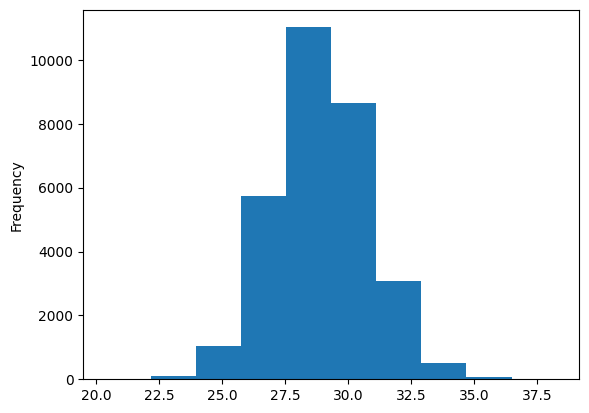

In [32]:
import spacy

nlp = spacy.load("en_core_web_lg")
wos_nlp = wos.merge(wos_kwd_concat, on=record_col)
wos_nlp["Document"] = wos_nlp["Article Title"].str.cat(wos_nlp[["Abstract", "keyword_all"]].fillna(""), sep=' - ')
# wos_kwd_test["BERT_KWDS"] = wos_kwd_test["Document"].map(kwd_extract)

vectors = list()
vector_norms = list()

for doc in nlp.pipe(wos_nlp['Document'].astype('unicode').values, batch_size=300,
                    n_process=4):
    vectors.append(doc.vector)
    vector_norms.append(doc.vector_norm)

wos_nlp['vector'] = vectors
wos_nlp['vector_norm'] = vector_norms
wos_nlp['vector_norm'].plot(kind="hist")

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline

vector_data = pd.DataFrame(wos_nlp["vector"].to_list(), index=wos_nlp[record_col]).reset_index()
vector_data.head()

labels = vector_data.values[:, 0]
record_vectors = vector_data.values[:, 1:]

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=42, metric='cosine')
tnse_2d = tsne_model.fit_transform(record_vectors)
tnse_data = pd.DataFrame(tnse_2d, index=labels).reset_index()
tnse_data.columns = [record_col, "TNSE-X", "TNSE-Y"]
tnse_data.head()

UT (Unique WOS ID)      TNSE-X     TNSE-Y
0  WOS:000641589600020  131.783783  -4.202979
1  WOS:000590197400003   74.897812  89.280334
2  WOS:000510863400004   84.939049  23.416033
3  WOS:000403039400031  -39.527546  54.230900
4  WOS:000439363600016  -59.109379  72.877693

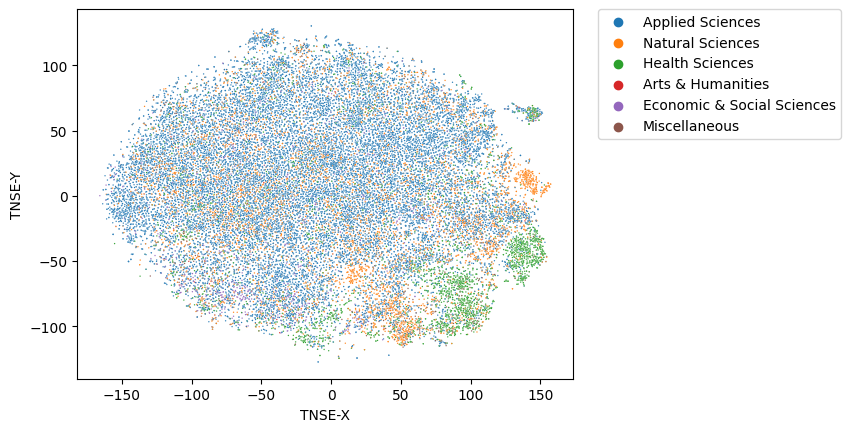

In [36]:
wos_plot = wos_nlp.merge(tnse_data, on=record_col)

g = sns.scatterplot(wos_plot[wos_plot["Domain_English"] != 'article-level classification'], x="TNSE-X", y="TNSE-Y",
                    hue='Domain_English', s=1)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
wos_plot.head()
wos_nlp = wos_plot[[record_col, "Document", "keyword_all", "TNSE-X", "TNSE-Y"]]


In [40]:

wos_nlp.to_excel(f"{outdir}/wos_nlp.xlsx", index=False)

In [93]:
wos_nlp.to_csv(f"{outdir}/wos_nlp.csv", index=False, sep='\t')

In [37]:
wos_nlp.columns

Index(['UT (Unique WOS ID)', 'Document', 'keyword_all', 'TNSE-X', 'TNSE-Y'], dtype='object')

<Axes: ylabel='Frequency'>

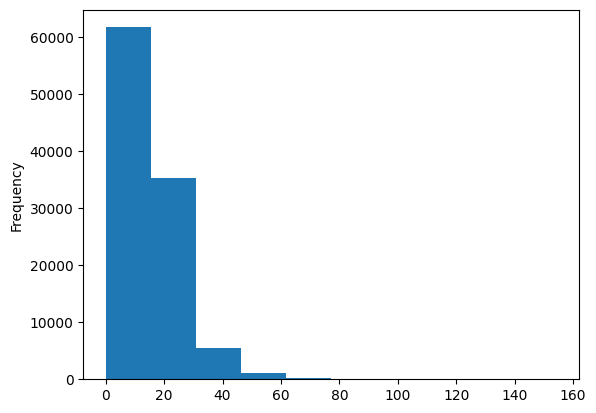

In [94]:
import spacy

nlp = spacy.load("en_core_web_lg")
kwd_nlp = pd.DataFrame(kw_df["keyword_all"].drop_duplicates())
# wos_kwd_test["BERT_KWDS"] = wos_kwd_test["Document"].map(kwd_extract)

vectors = list()
vector_norms = list()

for doc in nlp.pipe(kwd_nlp['keyword_all'].astype('unicode').values, batch_size=300,
                    n_process=4):
    vectors.append(doc.vector)
    vector_norms.append(doc.vector_norm)

kwd_nlp['vector'] = vectors
kwd_nlp['vector_norm'] = vector_norms
kwd_nlp['vector_norm'].plot(kind="hist")

In [95]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline

vector_data = pd.DataFrame(kwd_nlp["vector"].to_list(), index=kwd_nlp["keyword_all"]).reset_index()
vector_data.head()

labels = vector_data.values[:, 0]
record_vectors = vector_data.values[:, 1:]

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=42, metric='cosine')
tnse_2d = tsne_model.fit_transform(record_vectors)
tnse_data = pd.DataFrame(tnse_2d, index=labels).reset_index()
tnse_data.columns = [record_col, "TNSE-X", "TNSE-Y"]
tnse_data.head()

UT (Unique WOS ID)      TNSE-X      TNSE-Y
0      COMPARATIVE GENOMICS -114.811630  -43.915569
1                   ANAMMOX    8.044455  100.761032
2  KUENENIA STUTTGARTIENSIS    8.044455  100.761032
3              METAGENOMICS    8.044455  100.761032
4        ENRICHMENT CULTURE  -99.356590  -78.270439

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


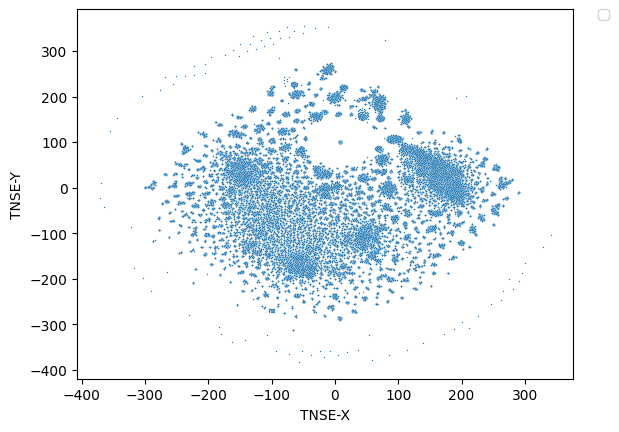

In [96]:
g = sns.scatterplot(tnse_data, x="TNSE-X", y="TNSE-Y", s=1)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [99]:
wos_nlp.to_csv(f"{outdir}/wos_nlp.csv", index=False, sep='\t')
tnse_data.to_csv(f"{outdir}/kw_nlp.csv", index=False, sep='\t')

wos_nlp.to_excel(f"{outdir}/wos_nlp.xlsx", index=False)
tnse_data.drop_duplicates(subset=record_col).to_excel(f"{outdir}/kw_nlp.xlsx", index=False)